In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from evaluation import *

## I. Read in data:

In [2]:
data=pd.read_csv('user_subset.csv')
song = pd.read_csv('meta_data_subset.csv')
data, song = data.iloc[:,1:], song.iloc[:,1:]
song = song.rename(columns = {'song_id':'Song'})
data = pd.merge(data, song, how = 'inner', on = 'Song')
data.head()

,Usr,Song,Time,title,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness
0,5a905f000fc1ff3df7ca807d57edb608863db05d,SOEBCBI12AF72A154F,5,The Captain,NaN,368.79628,4,-11.194,0,105.02,The Knife,0.487848
1,761601781ea89218ebe21c4ccaa996e7a6479671,SOEBCBI12AF72A154F,1,The Captain,NaN,368.79628,4,-11.194,0,105.02,The Knife,0.487848
2,55fc5990fc7911cfbba36c6ae26bfa3f532d8627,SOEBCBI12AF72A154F,1,The Captain,NaN,368.79628,4,-11.194,0,105.02,The Knife,0.487848
3,ea11e93ba014e8ff4cf302ac548d9246f2b76918,SOEBCBI12AF72A154F,3,The Captain,NaN,368.79628,4,-11.194,0,105.02,The Knife,0.487848
4,e3b48b679fc7215d3c7b29c6b944b34c6019a29a,SOEBCBI12AF72A154F,1,The Captain,NaN,368.79628,4,-11.194,0,105.02,The Knife,0.487848


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151057 entries, 0 to 151056
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Usr             151057 non-null  object 
 1   Song            151057 non-null  object 
 2   Time            151057 non-null  int64  
 3   title           151057 non-null  object 
 4   song_hotness    133813 non-null  float64
 5   duration        151057 non-null  float64
 6   key             151057 non-null  int64  
 7   loudness        151057 non-null  float64
 8   mode            151057 non-null  int64  
 9   tempo           151057 non-null  float64
 10  artist          151057 non-null  object 
 11  artist_hotness  151057 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 15.0+ MB


In [4]:
# labeling and encoding:
user_encoder = LabelEncoder()
data['Usr'] = user_encoder.fit_transform(data['Usr'].values)

song_encoder = LabelEncoder()
data['Song'] = song_encoder.fit_transform(data['Song'].values)
data.astype({'Usr': 'int32', 'Song': 'int32', 'Time': 'int32'})

,Usr,Song,Time,title,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness
0,8021,519,5,The Captain,NaN,368.79628,4,-11.194,0,105.020,The Knife,0.487848
1,10432,519,1,The Captain,NaN,368.79628,4,-11.194,0,105.020,The Knife,0.487848
2,7609,519,1,The Captain,NaN,368.79628,4,-11.194,0,105.020,The Knife,0.487848
3,20892,519,3,The Captain,NaN,368.79628,4,-11.194,0,105.020,The Knife,0.487848
4,20336,519,1,The Captain,NaN,368.79628,4,-11.194,0,105.020,The Knife,0.487848
...,...,...,...,...,...,...,...,...,...,...,...,...
151052,15128,1922,2,Intensity In Ten Cities,0.547953,247.48363,7,-3.402,1,231.851,Embrace the End,0.420177
151053,11818,1615,3,Cabiria,0.473347,203.96363,0,-10.881,1,132.073,Hot Club Of Cowtown,0.389848
151054,9494,1543,1,Safe Passage,0.265861,330.97098,7,-16.934,1,101.529,Michael Gettel,0.333771
151055,9494,2823,1,River Run,0.262309,452.25751,1,-16.685,0,168.035,Michael Gettel,0.333771


## II. Train test split:

In [5]:
user_id = data['Usr'].unique()
train_uid,test_uid = user_id[:22700],user_id[22700:]
train = data[data['Usr'].isin(train_uid)]
song_id = train['Song'].unique()

# Test user only keep songs have overlap with train user song lists, and delete user with personal songlist < 4:
test = data[data['Usr'].isin(test_uid) & data['Song'].isin(song_id)]
temp = test.groupby('Usr').count()['Song'].reset_index()
uid = temp[temp['Song'] >= 4]['Usr']
del temp
test = test[test['Usr'].isin(uid)]

In [6]:
# For each test user, keep 2 songs as known; And other songs in the song list as hidden songs.
# The hidden songs will be used to test the performance of the recommendation system later.

# X: For user based recommendation
# user_hidden_songs: test user and hidden song list.
user_song = {}
for user, group in test.groupby('Usr'):
    user_song[user] = group['Song'].values.tolist()    
test1 = []
for user in user_song:
    for i in range(2):
        test1.append(test[(test['Usr']==user)&(test['Song']==user_song[user][i])].squeeze())
test1 = pd.DataFrame(test1)
X = pd.concat([train,test1])
del test1
del train

test_hidden = []
for user in user_song:
    for i in range(2,len(user_song[user])):
        test_hidden.append(test[(test['Usr']==user)&(test['Song']==user_song[user][i])].squeeze())
test_hidden = pd.DataFrame(test_hidden)[['Usr','Song']]

user_hidden_songs = {}
for user, group in test_hidden.groupby('Usr'):
    user_hidden_songs[user] = group['Song'].values.tolist()
del test_hidden

## III. EDA

In [7]:
# Distribution of playcounts per user (user_playcounts)
user_playcounts = {}
for user, group in X.groupby('Usr'):
    user_playcounts[user] = group['Time'].sum()

/Users/hyw/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


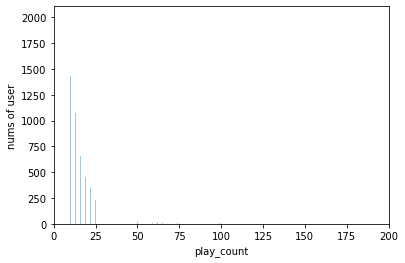

In [8]:
sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of user')
plt.show()

In [9]:
# Distribution of playcounts per song (song_playcounts)
song_playcounts = {}
for song, group in X.groupby('Song'):
    song_playcounts[song] = group['Time'].sum() 

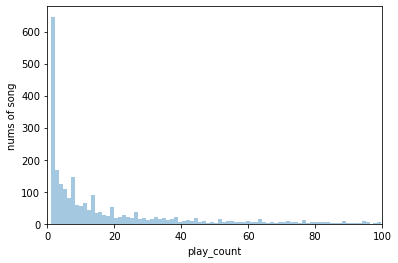

In [10]:
sns.distplot(list(song_playcounts.values()), bins=10000, kde=False)
plt.xlim(0, 100)
plt.xlabel('play_count')
plt.ylabel('nums of song')
plt.show()

In [11]:
user_averageScore = {}
for Usr, group in X.groupby('Usr'):
    user_averageScore[Usr] = group['Time'].mean()

In [12]:
X['rating'] = X.apply(lambda x: np.log(2 + x.Time / user_averageScore[x.Usr]), axis=1)

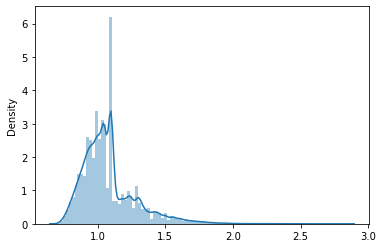

In [13]:
sns.distplot(X['rating'].values, bins=100)
plt.show()

In [14]:
user_item_rating = X[['Usr', 'Song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'Song': 'item'})

In [15]:
# User and their corresponding song list
user_songs = {}
for user, group in user_item_rating.groupby('Usr'):
    user_songs[user] = group['item'].values.tolist()

# unique songs
songs = user_item_rating['item'].unique().tolist()

In [16]:
user_item_rating.head()

,Usr,item,rating
0,8021,519,1.452252
1,10432,519,0.897942
2,7609,519,1.098612
3,20892,519,1.038508
4,20336,519,0.969401


## IV. Recommendation

#### 1. User based recall

In [17]:
# User based Collaborative Filtering:

reader = Reader(line_format='user item rating', sep=',')
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
kf = KFold(n_splits=2)
knn_usercf = KNNBasic(k=40, sim_options={'user_based': True})
for trainset, testset in kf.split(raw_data):
    knn_usercf.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


#### 2. Content-based sorting

In [18]:
from sklearn.preprocessing import StandardScaler
attr = X.drop(['Usr', 'title', 'Time', 'song_hotness', 'artist'], axis=1).drop_duplicates().set_index('Song')
scaler = StandardScaler()
attr_std = scaler.fit_transform(attr)
attr_df = pd.DataFrame(attr_std, index=attr.index, columns=attr.columns)

# (song_id, title)
song_title = dict(zip(data['Song'], data['title']))
# (song_id, normalized metadata attributes)
song_attr = dict(zip(attr_df.index, attr_df.values.tolist()))

In [19]:
# Content based similarity sorting:
def content_based_sorting(rec_items, used_items):
    
    # Calc cosine similarity:
    def cosine_sim(x, y):
        x,y = np.array(x), np.array(y)
        return np.dot(x, y)/(norm(x)*norm(y))
    
    # (song, total similarity between current song and all songs in user historic song list):
    sim = {}
    for sid in rec_items:
        sim[sid] = sum([cosine_sim(song_attr[sid], song_attr[ssid]) for ssid in used_items])
    song_ids = dict(sorted(sim.items(), key=lambda x: x[1], reverse=True))
    return list(song_ids.keys())

#### 3. Final recommender

In [20]:
# Return a song list based on User CF and sorting by different criteria:
def recommendation_basedonUserCF(userID, N=2906, sorting = 'item_sim'):
    used_items = user_songs[userID]
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_usercf.predict(userID, item).est
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    if sorting == 'item_sim':
        return content_based_sorting(list(song_ids.keys()), used_items)
    return list(song_ids.keys())

## V. Performance Evaluation:

In [21]:
## I. Accuracy Score
acc = [acc_score(recommendation_basedonUserCF(k,N=50),user_hidden_songs[k]) for k in user_hidden_songs]
print('The average accuracy of 50 recommended song list:', np.mean(acc))

The average accuracy of 50 recommended song list: 0.005714285714285714


In [22]:
## II. mean precision:
mean_pre_1 = [mean_precision(recommendation_basedonUserCF(k),user_hidden_songs[k]) for k in user_hidden_songs]
mean_pre_2 = [mean_precision(recommendation_basedonUserCF(k,sorting='Default'),user_hidden_songs[k]) for k in user_hidden_songs]

print('The average mean precision based on item similarity sorting:', np.mean(mean_pre_1))
print('The average mean precision based on raw user rating sorting:', np.mean(mean_pre_2))

The average mean precision based on item similarity sorting: 0.08270241218384498
The average mean precision based on raw user rating sorting: 0.08941462808810677


In [23]:
norm_pre_1 = [norm_precision(recommendation_basedonUserCF(k),user_hidden_songs[k]) for k in user_hidden_songs]
norm_pre_2 = [norm_precision(recommendation_basedonUserCF(k,sorting='Default'),user_hidden_songs[k]) for k in user_hidden_songs]

print('The average normalized precision based on item similarity sorting:', np.mean(norm_pre_1))
print('The average normalized precision based on raw user rating sorting:', np.mean(norm_pre_2))

The average normalized precision based on item similarity sorting: 0.2579409553628042
The average normalized precision based on raw user rating sorting: 0.20218176539006003
